In [1]:
# import PyTorch and its related packages
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch

import torchvision
import torchvision.transforms as transforms

from torchvision import transforms
from torchvision.datasets import ImageFolder

from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix


# set default device based on CUDA's availability
device = 'cuda' if T.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

batch_size = 64
#image_size = (224, 224, 3)

train_set = ImageFolder('C:/Users/heuma/Desktop/Work/Reseaux_test/Dataset_Kaggle/output/train', transform=transform)
validation_set = ImageFolder('C:/Users/heuma/Desktop/Work/Reseaux_test/Dataset_Kaggle/output/val', transform=transform)
test_set = ImageFolder('C:/Users/heuma/Desktop/Work/Reseaux_test/Dataset_Kaggle/output/test', transform=transform)

#train_set = train_ds
train_loader = T.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True, num_workers=8)

#validation_set = validation_ds
validation_loader = T.utils.data.DataLoader(validation_set, batch_size=batch_size,shuffle=True, num_workers=8)

#test_set = test_ds
test_loader = T.utils.data.DataLoader(test_set, batch_size=batch_size,shuffle=True, num_workers=8)

In [3]:
class NewNetwork(nn.Module):
    def __init__(self, num_classes=291):
        super(NewNetwork, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.1),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.2),
            nn.Conv2d(192, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.3),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.3)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(16 * 8 * 8, 2000), #mettre 128 quand il y a 5 couches
            nn.PReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(2000, 1000),
            nn.PReLU(),
            nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [4]:
net = NewNetwork()
net.to(device)

NewNetwork(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.3, inplace=False)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Dropo

In [5]:
criterion = nn.CrossEntropyLoss()

# also the optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#dynamic learning rate
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [6]:
train_loss = []
validation_loss = []
train_acc = []
validation_acc = []

lrs = []
steps = []

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

for epoch in tqdm(range(0, 70)):  # loop over the dataset multiple times
    
    running_loss = .0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader):
        # get the inputs
        inputs, labels = data
        if device == 'cuda':
            inputs, labels = inputs.to(device), labels.to(device)

        # reset the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # backward
        loss.backward()
        # optimize
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = T.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    running_loss /= len(train_loader)
    train_loss.append(running_loss)
    running_acc = correct / total
    train_acc.append(running_acc)
    
    #zone pour mettre le learning rate dynamique
    """
    steps.append(epoch)
    lrs.append(scheduler.get_last_lr()[0])
    scheduler.step()
    """
    
    if epoch % 5 == 0:
        print('\nEpoch: {}'.format(epoch))
    #    print('Train Acc. => {:.3f}%'.format(100 * running_acc), end=' | ')
        print('Train Loss => {:.5f}'.format(running_loss))
    
    # evaluate on the validation set
    # note this is usually performed on the validation set
    # for simplicity we just evaluate it on the validation set
    with T.no_grad():
        correct = 0
        total = 0
        validation_running_loss = .0
        for data in validation_loader:
            inputs, labels = data
            if device == 'cuda':
                inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            validation_running_loss += loss.item()
            _, predicted = T.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if epoch == 99:
                # Append batch prediction results
                predlist=torch.cat([predlist,predicted.view(-1).cpu()])
                lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

        validation_running_loss /= len(validation_loader)
        validation_loss.append(validation_running_loss)
        validation_running_acc = correct / total
        validation_acc.append(validation_running_acc)
        
        if epoch % 5 == 0:
            print('validation Acc.  => {:.3f}%'.format(100 * validation_running_acc), end=' | ')
            print('validation Loss  => {:.5f}'.format(validation_running_loss))

print('Finished Training')

  0%|          | 0/70 [00:00<?, ?it/s]


Epoch: 0
Train Loss => 5.56203
validation Acc.  => 1.193% | validation Loss  => 5.46393

Epoch: 5
Train Loss => 4.51207
validation Acc.  => 4.223% | validation Loss  => 4.45171

Epoch: 10
Train Loss => 3.51724
validation Acc.  => 15.700% | validation Loss  => 3.42889

Epoch: 15
Train Loss => 2.08651
validation Acc.  => 38.991% | validation Loss  => 2.16747

Epoch: 20
Train Loss => 1.38880
validation Acc.  => 58.075% | validation Loss  => 1.40404

Epoch: 25
Train Loss => 1.02662
validation Acc.  => 65.023% | validation Loss  => 1.13597

Epoch: 30
Train Loss => 0.83219
validation Acc.  => 69.423% | validation Loss  => 0.98058

Epoch: 35
Train Loss => 0.69856
validation Acc.  => 73.372% | validation Loss  => 0.88707

Epoch: 40
Train Loss => 0.61004
validation Acc.  => 75.113% | validation Loss  => 0.84517

Epoch: 45
Train Loss => 0.53644
validation Acc.  => 76.306% | validation Loss  => 0.79845

Epoch: 50
Train Loss => 0.47554
validation Acc.  => 78.063% | validation Loss  => 0.76416

Ep

## Test

In [9]:
# TODO: Do validation on the test set

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on test images: %d %%' % (100 * correct / total))

Accuracy of the network on test images: 78 %


## Visualization

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)


[]


ValueError: zero-size array to reduction operation fmin which has no identity

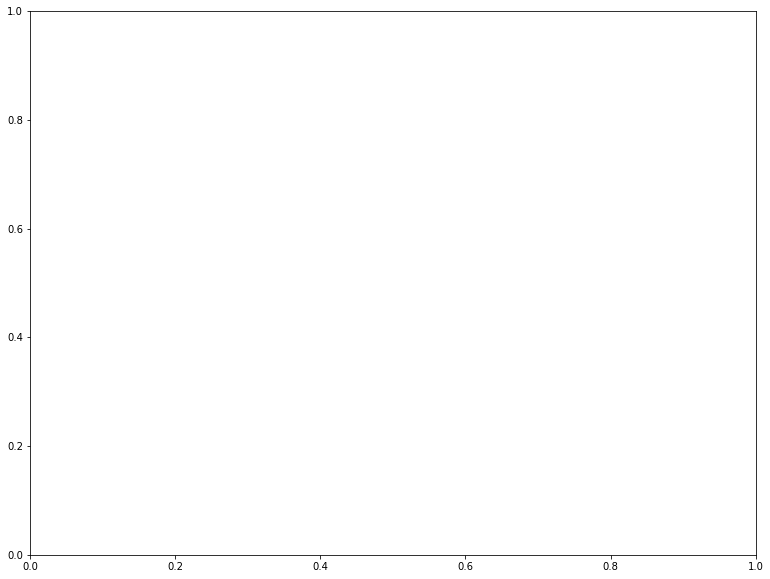

In [13]:
fig, ax = plt.subplots(figsize=(13,10))
sns.heatmap(conf_mat, annot=False, ax=ax, cmap="BuPu")

In [14]:
# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[]


In [15]:
"""
plt.plot(steps, lrs)
plt.xlabel("epoch")
plt.ylabel("learning rate values")
plt.title("learning rate's curve")
plt.show()
"""

'\nplt.plot(steps, lrs)\nplt.xlabel("epoch")\nplt.ylabel("learning rate values")\nplt.title("learning rate\'s curve")\nplt.show()\n'

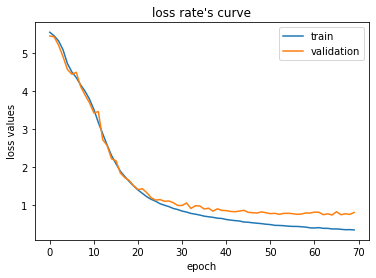

In [16]:
plt.plot(train_loss, label='train')
plt.plot(validation_loss, label='validation')
plt.xlabel("epoch")
plt.ylabel("loss values")
plt.title("loss rate's curve")
plt.legend()
plt.show()

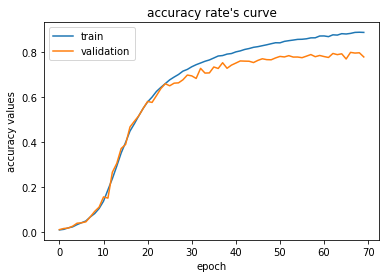

In [17]:
plt.plot(train_acc, label='train')
plt.plot(validation_acc, label='validation')
plt.xlabel("epoch")
plt.ylabel("accuracy values")
plt.title("accuracy rate's curve")
plt.legend()
plt.show()

## Save

In [ ]:
#torch.save(net.state_dict(), "C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_validation_Train_20-80/dict_Linh_network_1st_try")

In [ ]:
#torch.save(net, "C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_validation_Train_20-80/Linh_network_entire_model_1st_try")

In [ ]:
"""
from torch.utils.data.dataloader import DataLoader


train_dl = DataLoader(train_set, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

from torchvision.utils import make_grid

def show_batch(dl):
    #Plot images grid of single batch
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

"""

In [ ]:
"""
transform2 = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor()])

train_set2 = ImageFolder('C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_validation_Train_20-80/TRAIN/', transform=transform2)

train_dl2 = DataLoader(train_set2, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

        
show_batch(train_dl2)
"""